## Numerical Methods In Finance | fall 2024

### *Seminar 12*

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.sparse.linalg import splu, spsolve
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from pde_solver import solve_1d_pde, FiniteDifferencingScheme
from pricer import price, OptionType
from typing import Union

### 1. Numerical methods for solving parabolic PDEs

#### 1.1 From Black-Scholes-Merton PDE to Heat Equation

+ The Black–Scholes–Merton equation is a partial differential equation (PDE) which governs the price evolution of the derivative contract under the Black–Scholes-Merton model.

+ The derivative is not necessarily a European vanilla call or put option and may have an arbitrary payoff function $g(S)$ at expiration $T$. That is, in European vanilla case, $g(S) = (S_T - K)_{+}$ for calls and $g(S) = (K - S_T)_{+}$ for puts. 

+ Under the assumptions that the given asset (e.g. stock) $S$ pays no dividends, the price of the derivative contract satisfies 

$$\begin{cases} \dfrac{\partial V}{\partial t} + \dfrac{1}{2} \sigma^2 S^2 \dfrac{\partial^2 V}{\partial S^2} + rS \dfrac{\partial V}{\partial S} - rV = 0, \\\\ V(T, s) = g(s)\end{cases}.$$ 

+ From practical point of view, the PDE above turns to be an effective P&L of the delta-hedged derivative.  From mathematical point of view, the solution of the PDE above can be obtained using the Feynman-Kac formula, which states that 

$$V(t, S) = \mathbb{E}^{\mathbb{Q}} \left[ e^{-r(T-t)} \cdot g(S_T) | S_t = S\right],$$
$$S_t = S_0 \cdot e^{(r - \sigma^2/2)t + \sigma W_t} \quad \text{under} \quad \mathbb{Q}.$$


**How can the BSM PDE be transformed to heat equation?**

Consider a change of variables

$$(S, V) \to (x, u),$$
$$\quad x = \ln(S/S_0) + (r - \sigma^2/2)(T-t), \quad u = V \cdot e^{r(T-t)}.$$
Then it can be shown that $u(t, x)$ satisfies the **inverse heat eqaution** with the initial condition

$$\begin{cases} \dfrac{\partial u}{\partial t} = - \dfrac{1}{2}\sigma^2\dfrac{\partial^2 u}{\partial x^2}, \\\\ u(T, x) =g(S_0 e^{x}). \end{cases}$$ 


Moreover, we may invert time $t$ to obtain a standard **heat eqution**

$$t \to T - t$$
$$\begin{cases} \dfrac{\partial u}{\partial \tau} = \dfrac{1}{2}\sigma^2\dfrac{\partial^2 u}{\partial x^2}, \\\\ u(0, x) =g(S_0 e^{x}). \end{cases}$$ 
The question of setting the **boundary values** will be discussed later.  

#### 1.2 Numerical schemes for heat equation

Dealing with heat equation, one basically faces with three types of numerical schemes solving it: 

+ Explicit,

+ Implicit,

+ Mixture of explicit and implicit (also called Crank-Nicolson scheme). 

Consider the time grid consiting of $M$ time points with step $\delta t = \dfrac{T}{M - 1}$

$$G^T_M = [0, \quad \delta t, \quad 2 \delta t, \quad \dots, \quad T]$$

and the symmetric space grid consiting of $N = 2K + 1$ space points 

$$G^X_N = [- K \cdot \delta x, \quad (- K + 1) \cdot \delta x, \quad \cdots, \quad (K - 1)\cdot \delta x, \quad K \cdot \delta x].$$

Let $$u^{m}_{n} := u(m \cdot \delta t, (-K + n) \cdot \delta x),$$
denoting the $n$-th in space and $m$-th in time value of function $u$ on grid $G^T_M \times G^X_N$. 

Then the finite differencing scheme for $u^{m}_{n}$ can be written as 


$$ \dfrac{u^{m + 1}_{n} - u^{m}_{n}}{\delta \tau} = (1 - \theta) \cdot \dfrac{u^{m}_{n+1} - 2 u^{m}_{n} + u^{m}_{n-1}}{(\delta x)^2} + \theta \cdot \dfrac{u^{m+1}_{n+1} - 2 u^{m+1}_{n} + u^{m+1}_{n-1}}{(\delta x)^2}, \quad \theta \in [0, 1].
$$

+ For $\theta = 0$ we get exactly an **Explicit** scheme.

+ For $\theta = 1$ we get exactly an **Implicit** scheme.

+ For $\theta = \frac{1}{2}$ we get a **Crank-Nicolson** scheme.

The scheme above can be rewritten in the form


$$ \left( 1 - (1 - \theta)\dfrac{2 \delta \tau}{(\delta x)^2} \right) u^{m}_n + (1 - \theta) \dfrac{\delta \tau}{(\delta x)^2} \left( u^{m}_{n+1} + u^{m}_{n-1} \right) = \left(1 + \theta \dfrac{2 \delta \tau}{(\delta x)^2} \right)u^{m+1}_n - \theta \dfrac{\delta \tau}{(\delta x)^2} \left( u^{m+1}_{n+1} + u^{m+1}_{n-1} \right),$$


which can be rewritten in matrix notation as 

$$\bold{\tilde  A} \cdot u^{m} =  \bold{\tilde B} \cdot u^{m+1}$$

with 

$$\bold{\tilde  A} = \bold{\left(I + (1 - \theta) \delta \tau \Lambda\right)}, \qquad \bold{\tilde  B} =  \bold{\left(I - \theta \delta \tau \Lambda\right)},$$


and 

$$\bold{\Lambda} \cdot u_n = \dfrac{u_{n+1} - 2u_n + u_{n-1}}{\delta x^2}.$$


$$
\begin{align*}
\bold{\tilde A} = 
\left(
\begin{matrix} 
1 - p & (1 - \theta)p & 0 & 0 &  \cdots & 0 \\ 
(1 - \theta) p & 1 -p & (1 - \theta) p  & 0 & \cdots & \vdots\\
0 & (1 - \theta) p & 1 - p & (1 - \theta) p  & \cdots & \vdots\\
\vdots & \vdots & \vdots & \cdots & \ddots & \vdots\\ 
\vdots & \vdots & \vdots & (1 - \theta) p & 1-p & (1 - \theta) p \\ 
0 & 0 & 0 & 0 & (1 - \theta) p & 1 - p \\   
\end{matrix}
\right), 
\quad
\bold{\tilde B} = 
\left(
\begin{matrix} 
1 + p & - \theta p & 0 & 0 &  \cdots & 0 \\ 
- \theta p & 1 + p & - \theta p & 0 & \cdots & \vdots\\
0 & - \theta p & 1 + p & - \theta p  & \cdots & \vdots\\
\vdots & \vdots & \vdots & \cdots & \ddots & \vdots\\ 
\vdots & \vdots & \vdots & -\theta p & 1+p & -\theta p \\ 
0 & 0 & 0 & 0 & -\theta p & 1 + p \\   
\end{matrix}
\right)
\end{align*}, 
\quad 
\quad 
p = \dfrac{\delta \tau}{(\delta x)^2}.
$$

Therefore, to solve this system we need, effectively, two steps:

1. **If $\theta < 1$**,  forward propagation of $u^{m}$ with propagator $\bold{\tilde A = \left(I + (1 - \theta) \delta \tau \Lambda\right)}$, that is computation of $$u^{m+\frac{1}{2}} := \bold{\left(I + (1 - \theta) \delta \tau \Lambda\right)} \cdot u^{m}$$. 

2. **If $\theta > 0$**, solving the equation with matrix $\bold{\tilde B = \left( I - \theta \delta \tau \Lambda\right)} $ and right hand side $u^{m+\frac{1}{2}}$, that is finding such $u^{m+1}$ that

$$\bold{\left(I - \theta \delta \tau \Lambda\right)} \cdot u^{m+1} = u^{m+\frac{1}{2}}.$$

#### 1.3 Stability and convergence

The first ingredient to obtain the **convergence** of numerical algorithm is the **approximation order**, which describes how good a finite difference scheme approximates the differential equation. 



+ For $\theta = 0$, an **Explicit** scheme: 

$$O(\delta \tau) + O((\delta x)^2)$$

+ For $\theta = 1$, an **Implicit** scheme:

$$O(\delta \tau) + O((\delta x)^2)$$

+ For $\theta = \frac{1}{2}$, a **Crank-Nicolson** scheme:

$$O((\delta \tau)^2) + O((\delta x)^2)$$

The second ingredient for **convergence** is stability of the numerical scheme. 

$$
\boxed{
    \begin{align*}
    &\dfrac{1}{2} \leq \theta \leq 1 \quad \Longrightarrow \quad \text{stability for } \forall  \delta \tau, \delta x.
    \\
    &0 \leq \theta < \dfrac{1}{2}\quad \Longrightarrow \quad \text{stability for } \delta \tau \leq \dfrac{(\delta x)^2}{2 - 4\theta}.
    \end{align*}
}
$$

For our special cases, we get 

$$
\boxed{
    \begin{align*}
    &\text{Explicit, } \quad \theta = 0 \quad \Longrightarrow \quad \text{stability for } \delta \tau \leq \dfrac{(\delta x)^2}{2}. \\
    &\text{Explicit, } \quad \theta = 1 \quad \Longrightarrow \quad \text{stability for } \forall  \delta \tau, \delta x.\\
    &\text{Crank-Nicolson, } \quad \theta = 1/2 \quad \Longrightarrow \quad \text{stability for } \forall  \delta \tau, \delta x. 
    \end{align*}
}
$$

Combining the **approximation order** with **stability** we obtain the **convergence** (Filippov's theorem), which means that the solution of finite difference problem converges (in some norm) to a real soluion of PDE. 


$$
\Large
\boxed{
\textbf{Approximation}
} 
\quad 
+ 
\quad
\Large
\boxed{
\textbf{Stability}
} 
\quad 
= 
\quad
\Large
\boxed{
\textbf{Convergence}
}
$$

#### 1.4 Solving linear equation with tridiagonal matrix

Numerical schemes with $\theta > 0$ require the inversion of 

$$\bold{\tilde B =  I - \theta \delta \tau \Lambda }.$$

In general, matrix inversion requires $O(n^3)$ operations. However, for a tridiagonal matrices it can be essenatially reduced.

Consider a tridiagonal matrix $\textbf{B}$ of size $n \times n$

$$
\begin{align*}
\textbf{B} = 
\left(
\begin{matrix} 
a_1 & c_1 &  &  &   &  \\ 
d_1 & a_2 & c_2 &  &  & \\
 & d_2 & a_3 & c_3  &  & \\
 &  & \ddots & \ddots & \ddots & \\ 
 &  &  & d_{n-2} & a_{n-1} & c_{n-1} \\ 
 &  &  &  & d_{n-1} & a_n \\   
\end{matrix}
\right)
\end{align*}
$$
which should be descomposed in $\textbf{B = LU}$ with 

$$
\begin{align*}
\textbf{L} = 
\left(
\begin{matrix} 
l_1 &  &  &  &   &  \\ 
\lambda_1 & l_2 &  &  &  & \\
 & \lambda_2 & l_3 &   &  & \\
 &  & \ddots & \ddots &  & \\ 
 &  &  & \lambda_{n-2} & l_{n-1}  \\ 
 &  &  &  & \lambda_{n-1} & l_n \\   
\end{matrix}
\right)
\end{align*}, 
\quad 
\begin{align*}
\textbf{U} = 
\left(
\begin{matrix} 
1 & u_1 &  &  &   &  \\ 
 & 1 & u_2 &  &  & \\
 & & 1 & \ddots &  & \\
 &  &  & \ddots &  & \\ 
 &  &  &  &  & u_{n-1} \\ 
 &  &  &  &  & 1 \\  
\end{matrix}
\right)
\end{align*}.
$$

Construction of the $\textbf{LU}$ decomposition can be obtained by directly multiplying the matrices $\textbf{L}$ and $\textbf{U}$ and solving the resulting equations

$$l_1 = a_1, \qquad u_1 = c_1 / l_1$$

$$\lambda_1 = d_1, \qquad l_2 = a_2 - \lambda_1 u_1, \qquad u_2 = c_2 / l_2.$$

$$\cdots$$

$$\lambda_{n-2} = d_{n-2}, \qquad l_{n-1} = a_{n-1} - \lambda_{n-2} u_{n-2}, \qquad u_{n-1} = c_{n-1} / l_{n-1}.$$

$$\lambda_{n-1} = d_{n-1}, \qquad l_{n} = a_{n} - \lambda_{n-1} u_{n-1}.$$



Overall, $\textbf{LU}$ decomposition requires

+ $2(n-1)$ multiplicative operations;
+ $n-1$ additive operations. 

But how to use it to solve a system of equations $Bx = b$? The idea is that within $\textbf{LU}$ decomposition we get that $x$ should be a solution of $LUx = b$. Hence, denoting by $y := Ux$, we need to solve firstly $Ly = b$ and then $Ux = y$. The overall algorithm is the following: 

1. Construct an $\textbf{LU}$ descomposition of a matrix $B$ using the formulas above. It takes $3(n-1)$ operatinos. 

2. Then the solution to the linear system $Ly = b$ is found by sequentially eliminating the unknown variables, starting from the first equation:

$$y_1 = b_1 / l_1, \quad y_i = (b_i - \lambda_{i-1} y_{i-1}) / l_i, \quad i = 2, \dots, n$$

It takes $n-1$ additive and $2(n-1) + 1$ multiplicative operations, which is totally $3(n-1) + 1$ operations. 

3. The final vector $x$ is found as a solution to the linear system $Ux = y$ by sequentially eliminating the unknown variables, starting with the last equation.

$$x_n = y_n, \quad x_i = y_i - u_{i} x_{i+1}, \quad i = n-1, \cdots, 1. $$

It takes $n-1$ additive and $n-1$ multiplicative operations, which is totally $2(n-1)$ operations. 


The total complexity is $8(n-1) + 1$ operations, which is, effectively, $O(n)$. 

**Storage**

Obviously, there is no need to store the whole matrix $\textbf{B}$ and matrices $\textbf{L}$ and $\textbf{U}$. The coomon practice is to store only vectos 
$$(a_1, \dots, a_{n}), \quad (c_1, \dots, c_{n-1}), \quad (d_1, \dots, d_{n-1}),$$
$$(l_1, \dots, l_{n}), \quad (\lambda_1, \dots, \lambda_{n-1}), \quad (u_1, \dots, u_{n-1}).$$

Hence, the memory complexity is also $O(n)$. 

**Correctness**

Why the $\textbf{LU}$ decomposition is feasible? It turns out that this decomposition is possibble if and only if 

$$det B_k \neq 0, \quad k = 1, \dots, n,$$

where $B_k$ are corner (principal) submatrices of matrix $B$

$$
\begin{align*}
B_k = 
\left(
\begin{matrix} 
b_{11} & b_{12} & \cdots  &  b_{1k}&  \\ 
b_{21} & b_{22} & \cdots &  b_{2k} & \\
\vdots & \vdots & \ddots & \vdots \\
b_{k1} & b_{k2} & \cdots  & b_{kk}\\
\end{matrix}
\right)
\end{align*}.
$$

Obvoisuly, in our case the generator matrix $B$ satisfies the conditons above, hence $\textbf{LU}$ decomposition is feasible. 

In [2]:
# Iniaitialize a sparse tridiagonal matrix B
B = csc_matrix([[1., 2., 0., 0., 0.], [3., 4., 5., 0., 0.], [0., 6., 7., 8., 0.], [0., 0., 9., 10., 11.],  [0., 0., 0., 12., 13.]], dtype=float)
B, B.data

(<Compressed Sparse Column sparse matrix of dtype 'float64'
 	with 13 stored elements and shape (5, 5)>,
 array([ 1.,  3.,  2.,  4.,  6.,  5.,  7.,  9.,  8., 10., 12., 11., 13.]))

If you wish to constuct a $\textbf{LU}$ decomposition once and then use it for various right parts $b$, use `splu` and then call ``solve`` method for each part $b$.


In [3]:
# Construct LU decomposition of B
B_inv = splu(B)
B_inv

In [4]:
# Initialize the right-hand side b
b = np.array([1., 2., 3., 4., 5], dtype=float)

In [5]:
# Solve Bx=b
x = B_inv.solve(b)
x

array([ 0.12244898,  0.43877551, -0.0244898 ,  0.06734694,  0.32244898])

In [6]:
# Check that Bx=b
b_backward = B.dot(x)
b, b_backward

(array([1., 2., 3., 4., 5.]), array([1., 2., 3., 4., 5.]))

If there is NO need to constuct a $\textbf{LU}$ decomposition once and then use it for various right parts $b$, you masy use `spsolve`, which gives a solution for a given right part $b$ and matrix $B$. 

In [7]:
# Solve imm
x = spsolve(B, b)
x

array([ 0.12244898,  0.43877551, -0.0244898 ,  0.06734694,  0.32244898])

#### 1.5 Numerical examples of solving heat equation

**Example 1. Constant terminal condition, Explicit scheme**

$$\begin{cases} \dfrac{\partial u}{\partial t} = - \dfrac{1}{2}\sigma^2\dfrac{\partial^2 u}{\partial x^2}, \\\\ u(t_{end}, x) = u(t, x_{min}) = u(t, x_{max}) = 0. \end{cases} \Rightarrow u(t, x) \equiv 0, \quad x \in [x_{min}, x_{max}], \quad t \in [t_{start}, t_{end}].$$ 

In [8]:
number_of_spatial_levels, number_of_time_steps = 101, 51
t_start, t_end = 0, 1
x_min, x_max = -1, 1
terminal_condition = np.vectorize(lambda x: 0.0)
sigma = 0.2
pde_coefficients = lambda _:  {"U": 0, "U_t": 1., "U_x": 0, "U_xx": 0.5 * sigma ** 2}

In [9]:
constant_test = solve_1d_pde(scheme=FiniteDifferencingScheme.Explicit, 
                      lower_boundary_condition=lambda x, t: 0.0,
                      upper_boundary_condition=lambda x, t: 0.0,
                      terminal_condition=terminal_condition,
                      pde_coefficients=pde_coefficients,
                      number_of_spatial_levels=number_of_spatial_levels,
                      number_of_time_steps=number_of_time_steps,
                      x_min=x_min,
                      x_max=x_max,
                      t_start=t_start,
                      t_end=t_end)

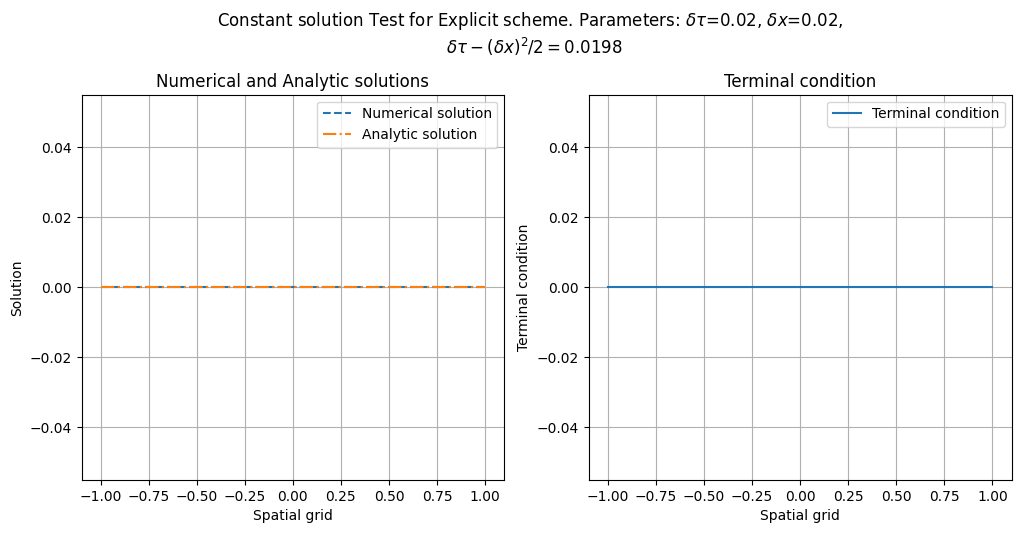

In [10]:
spatial_grid = constant_test["SpatialGrid"]
pde_solution = constant_test["FunctionValues"]
real_solution = np.zeros_like(pde_solution)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(spatial_grid, pde_solution, linestyle="--", label="Numerical solution")
ax[0].plot(spatial_grid, real_solution, linestyle="-.", label="Analytic solution")
ax[1].plot(spatial_grid, terminal_condition(spatial_grid), label="Terminal condition")

ax[0].set_title('Numerical and Analytic solutions'), ax[0].set_xlabel('Spatial grid'), ax[0].set_ylabel('Solution'), ax[0].legend()
ax[1].set_title('Terminal condition'), ax[1].set_xlabel('Spatial grid'), ax[1].set_ylabel('Terminal condition'), ax[1].legend()
ax[0].grid(), ax[1].grid()
dt, dx  = (t_end - t_start) / (number_of_time_steps - 1), (x_max - x_min) / (number_of_spatial_levels - 1)
fig.suptitle("Constant solution Test for Explicit scheme. Parameters: $\\delta \\tau$={}, $\\delta x$={}, \n $\\delta \\tau - (\\delta x)^2/2 = ${}".format(round(dt, 4), round(dx, 4), round(dt - (dx)**2 / 2, 6)), y=1.05)
plt.show()

**Example 2. Dirac terminal condition, Explicit scheme**

$$\begin{cases} \dfrac{\partial u}{\partial t} = - \dfrac{1}{2}\sigma^2\dfrac{\partial^2 u}{\partial x^2}, \\\\ u(1, x) = \delta_{0}(x), \quad u(t, x_{max}) = u(t, - x_{max}) = 0. \end{cases} \Rightarrow u(0, x) \approx \dfrac{1}{\sqrt{2\pi}\sigma} e^{-x^2/2\sigma^2}, \quad x \in [x_{min}, x_{max}], \quad t \in [t_{start}, t_{end}].$$ 

In [11]:
number_of_spatial_levels, number_of_time_steps = 101, 6001
t_start, t_end = 0, 1
x_min, x_max = -1, 1
sigma = 0.2
pde_coefficients = lambda _:  {"U": 0, "U_t": 1., "U_x": 0, "U_xx": 0.5 * sigma ** 2}
terminal_condition = np.vectorize(lambda x: 1./ (x_max - x_min) * number_of_spatial_levels if abs(x) <= 1e-5 else 0.)

In [12]:
gaussian_test = solve_1d_pde(scheme=FiniteDifferencingScheme.Explicit, 
                      lower_boundary_condition=lambda x, t: 0.0,
                      upper_boundary_condition=lambda x, t: 0.0,
                      terminal_condition=terminal_condition,
                      pde_coefficients=pde_coefficients,
                      number_of_spatial_levels=number_of_spatial_levels,
                      number_of_time_steps=number_of_time_steps,
                      x_min=x_min,
                      x_max=x_max,
                      t_start=t_start,
                      t_end=t_end)

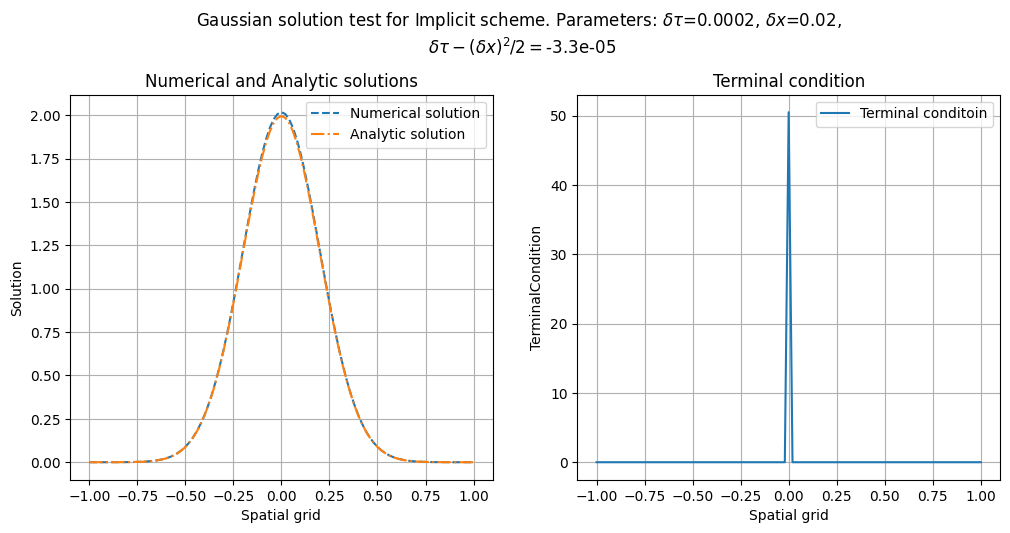

In [13]:
spatial_grid = gaussian_test["SpatialGrid"]
pde_solution = gaussian_test["FunctionValues"]
real_solution = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-np.linspace(x_min, x_max, number_of_spatial_levels) ** 2 / (2 * sigma ** 2)) 

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(spatial_grid, pde_solution, linestyle="--", label="Numerical solution")
ax[0].plot(spatial_grid, real_solution, linestyle="-.", label="Analytic solution")
ax[1].plot(spatial_grid, terminal_condition(spatial_grid), label="Terminal conditoin")


ax[0].set_title('Numerical and Analytic solutions'), ax[0].set_xlabel('Spatial grid'), ax[0].set_ylabel('Solution'), ax[0].legend()
ax[1].set_title('Terminal condition'), ax[1].set_xlabel('Spatial grid'), ax[1].set_ylabel('TerminalCondition'), ax[1].legend()
ax[0].grid(), ax[1].grid()
dt, dx  = (t_end - t_start) / (number_of_time_steps - 1), (x_max - x_min) / (number_of_spatial_levels - 1)
fig.suptitle("Gaussian solution test for Implicit scheme. Parameters: $\\delta \\tau$={}, $\\delta x$={}, \n $\\delta \\tau - (\\delta x)^2/2 = ${}".format(round(dt, 4), round(dx, 4), round(dt - (dx)**2 / 2, 6)), y=1.05)
plt.show()

**Example 3. Dirac terminal condition (crazy parameters), Explicit scheme**

In [14]:
number_of_spatial_levels, number_of_time_steps = 201, 201
t_start, t_end = 0, 1
x_min, x_max = -1, 1
sigma = 0.2
pde_coefficients = lambda _:  {"U": 0, "U_t": 1., "U_x": 0, "U_xx": 0.5 * sigma ** 2}
terminal_condition = np.vectorize(lambda x: 1./ (x_max - x_min) * number_of_spatial_levels if abs(x) <= 1e-5 else 0.)

In [15]:
gaussian_test_unstable = solve_1d_pde(scheme=FiniteDifferencingScheme.Explicit, 
                                    lower_boundary_condition=lambda x, t: 0,
                                    upper_boundary_condition=lambda x, t: 0,
                                    terminal_condition=terminal_condition,
                                    pde_coefficients=pde_coefficients,
                                    number_of_spatial_levels=number_of_spatial_levels,
                                    number_of_time_steps=number_of_time_steps,
                                    x_min=x_min,
                                    x_max=x_max,
                                    t_start=t_start,
                                    t_end=t_end)

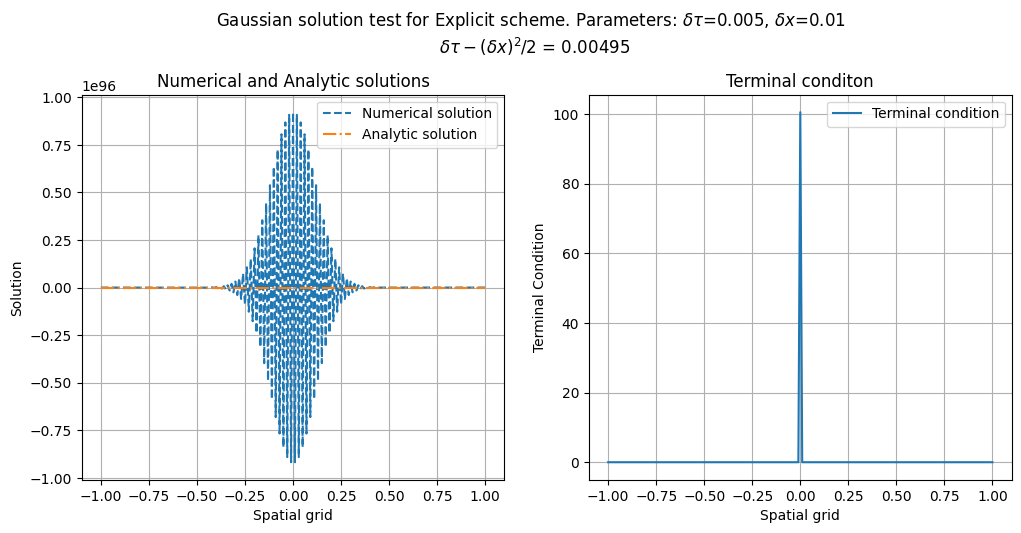

In [16]:
spatial_grid = gaussian_test_unstable["SpatialGrid"]
pde_solution = gaussian_test_unstable["FunctionValues"]
real_solution = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-np.linspace(x_min, x_max, number_of_spatial_levels) ** 2 / (2 * sigma ** 2)) 

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(spatial_grid, pde_solution, linestyle="--", label="Numerical solution")
ax[0].plot(spatial_grid, real_solution, linestyle="-.", label="Analytic solution")
ax[1].plot(spatial_grid, terminal_condition(spatial_grid), linestyle="-", label="Terminal condition")

ax[0].set_title('Numerical and Analytic solutions'), ax[0].set_xlabel('Spatial grid'), ax[0].set_ylabel('Solution'), ax[0].legend()
ax[1].set_title('Terminal conditon'), ax[1].set_xlabel('Spatial grid'), ax[1].set_ylabel('Terminal Condition'), ax[1].legend()
ax[0].grid(), ax[1].grid()
dt, dx  = (t_end - t_start) / (number_of_time_steps - 1), (x_max - x_min) / (number_of_spatial_levels - 1)
fig.suptitle("Gaussian solution test for Explicit scheme. Parameters: $\\delta \\tau$={}, $\\delta x$={} \n $\\delta \\tau - (\delta x)^2/2$ = {}".format(round(dt, 4), round(dx, 4), round(dt - (dx**2)/2, 6)), y=1.05)
plt.show()

**Example 4. Dirac terminal condition (crazy parameters), <ins>  Implicit </ins> scheme**

In [17]:
gaussian_test_implicit = solve_1d_pde(scheme=FiniteDifferencingScheme.Implicit, 
                                    lower_boundary_condition=lambda x, t: 0,
                                    upper_boundary_condition=lambda x, t: 0,
                                    terminal_condition=terminal_condition,
                                    pde_coefficients=pde_coefficients,
                                    number_of_spatial_levels=number_of_spatial_levels,
                                    number_of_time_steps=number_of_time_steps,
                                    x_min=x_min,
                                    x_max=x_max,
                                    t_start=t_start,
                                    t_end=t_end)

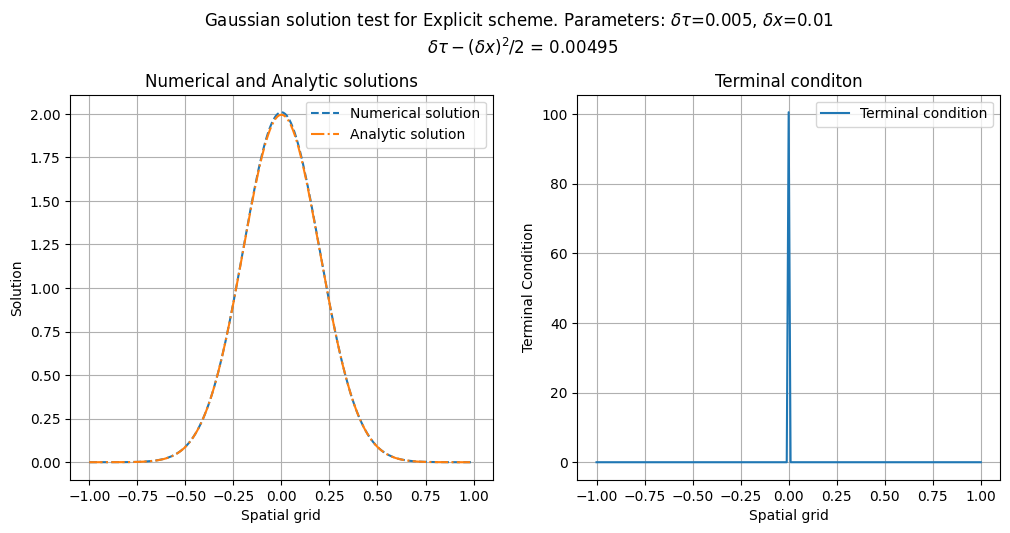

In [18]:
spatial_grid = gaussian_test_implicit["SpatialGrid"]
pde_solution = gaussian_test_implicit["FunctionValues"]
real_solution = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-np.linspace(x_min, x_max, number_of_spatial_levels) ** 2 / (2 * sigma ** 2)) 

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(spatial_grid, pde_solution, linestyle="--", label="Numerical solution")
ax[0].plot(spatial_grid, real_solution, linestyle="-.", label="Analytic solution")
ax[1].plot(spatial_grid, terminal_condition(spatial_grid), linestyle="-", label="Terminal condition")

ax[0].set_title('Numerical and Analytic solutions'), ax[0].set_xlabel('Spatial grid'), ax[0].set_ylabel('Solution'), ax[0].legend()
ax[1].set_title('Terminal conditon'), ax[1].set_xlabel('Spatial grid'), ax[1].set_ylabel('Terminal Condition'), ax[1].legend()
ax[0].grid(), ax[1].grid()
dt, dx  = (t_end - t_start) / (number_of_time_steps - 1), (x_max - x_min) / (number_of_spatial_levels - 1)
fig.suptitle("Gaussian solution test for Explicit scheme. Parameters: $\\delta \\tau$={}, $\\delta x$={} \n $\\delta \\tau - (\delta x)^2/2$ = {}".format(round(dt, 4), round(dx, 4), round(dt - (dx**2)/2, 6)), y=1.05)
plt.show()

### 2. Applications to options pricing

#### 2.1 Boundary and terminal conditions

$$dX_t = \sigma dW_t$$

$$X_t = \sigma W_t \sim N(0, t)$$


$$
\boxed{
x = \sigma W_t
} 
$$

+ **Boundary values**

$$x_{min} = - n_{std} \cdot \sigma \cdot \sqrt{T}, \quad x_{max} = n_{std} \cdot \sigma \cdot \sqrt{T},$$

where $n_{std}$ is the number of standard deviations which we wish to cover (for instance, $n_{std} = 4$). Notice that $\sigma \sqrt{T}$ is, effectively, a standard deviation of $W_T$.

<ins> Put options </ins>:

$$
\begin{align*}
u^{put}(t, x_{max}) &= 0, \\
u^{put}(t, x_{min}) &= \mathbb{E} \left[\left( K - S_T \right)_{+} | \sigma W_t = x_{min} \right]  = \mathbb{E} \left[ \left( K - S_0 e^{(r - \sigma^2/2)T + \sigma W_{T}} \right)_{+} \Big| \sigma W_t = x_{min} \right] \\
&=  \mathbb{E} \left[ \left( K - S_0 e^{(r - \sigma^2/2)T + \sigma W_t + \sigma W_{T-t}} \right)_{+} \Big| \sigma W_t = x_{min}\right] = \mathbb{E} \left[ \left( K - S_0 e^{(r - \sigma^2/2)T + x_{min} + \sigma W_{T-t}} \right)_{+}\right] \\
&\approx \mathbb{E} \left[ K - S_0 e^{(r - \sigma^2/2)T + x_{min} + \sigma W_{T-t}} \right] = K - S_0 e^{(r - \sigma^2/2)T + x_{min}} \cdot \mathbb{E} \left[ e^{\sigma W_{T-t}} \right] = \\
&= K - S_0 e^{(r - \sigma^2/2)T + x_{min}} \cdot e^{\sigma^2(T-t)/2} = K - S_0e^{rT - \sigma^2 t/2 + x_{min}} = \\
&= \boxed{e^{r(T-t)} \left( Ke^{-r(T-t)} - S_0  e^{x_{min} + (r - \sigma^2 / 2)  t} \right)}.\\
\end{align*}
$$

<ins> Call options </ins>:
 
$$
\begin{align*}
u^{call}(t, x_{min}) &= 0, \\
u^{call}(t, x_{max}) &= \mathbb{E} \left[\left( S_T - K \right)_{+} | \sigma W_t = x_{max} \right]  = \mathbb{E} \left[ \left( S_0 e^{(r - \sigma^2/2)T + \sigma W_{T}} - K\right)_{+} \Big| \sigma W_t = x_{max} \right] \\
&=  \mathbb{E} \left[ \left( S_0 e^{(r - \sigma^2/2)T + \sigma W_t + \sigma W_{T-t}} - K\right)_{+} \Big| \sigma W_t = x_{max}\right] = \mathbb{E} \left[ \left(S_0 e^{(r - \sigma^2/2)T + x_{max} + \sigma W_{T-t}} - K \right)_{+}\right] \\
&\approx \mathbb{E} \left[ S_0 e^{(r - \sigma^2/2)T + x_{max} + \sigma W_{T-t}}  - K\right] = S_0 e^{(r - \sigma^2/2)T + x_{max}} - K \cdot \mathbb{E} \left[ e^{\sigma W_{T-t}} \right] = \\
&= S_0 e^{(r - \sigma^2/2)T + x_{max}} \cdot e^{\sigma^2(T-t)/2} - K = S_0e^{rT - \sigma^2 t/2 + x_{max}} - K = \\
&= \boxed{e^{r(T-t)} \left( S_0  e^{x_{max} + (r - \sigma^2 / 2)  t} - Ke^{-r(T-t)} \right)}.\\
\end{align*}
$$

+ **Terminal condition**

$$t_{start} = 0, \quad t_{end} = T.$$

$$
\begin{align*}
u^{put}(T, x) =  \mathbb{E} \left[\left(K - S_T \right)_{+} | \sigma W_T = x \right] &=  \mathbb{E} \left[ \left( K - S_0 e^{(r - \sigma^2/2)T + \sigma W_{T}} \right)_{+} \Big| \sigma W_T = x \right] \\
&= \boxed{\left( K - S_0 e^{(r - \sigma^2/2)T + x} \right)_{+}}.
\end{align*}
$$

$$
\begin{align*}
u^{call}(T, x) =  \mathbb{E} \left[\left(S_T \right)_{+} - K| \sigma W_T = x \right] &=  \mathbb{E} \left[ \left( S_0 e^{(r - \sigma^2/2)T + \sigma W_{T}} - K\right)_{+} \Big| \sigma W_T = x \right] \\
&= \boxed{\left( S_0 e^{(r - \sigma^2/2)T + x} - K\right)_{+}}.
\end{align*}
$$

#### 2.2 Numerical examples

In [24]:
def black(log_moneyness: Union[float, np.ndarray], forward: float, vol: Union[np.ndarray, float], 
          df: float = 1, T: float = 1, theta: float = 1) -> Union[float, np.ndarray]:
    total_vol = vol * np.sqrt(T)
    d_1 = - theta * (log_moneyness / total_vol - total_vol / 2)
    d_2 = - theta * (log_moneyness / total_vol + total_vol / 2)   
    return df * theta * forward * (norm.cdf(d_1) - np.exp(log_moneyness) * norm.cdf(d_2))

In [25]:
number_of_time_steps = 31
finite_differencing_spacial_levels = 51
number_of_std_deviations = 4
scheme_type = FiniteDifferencingScheme.Implicit

In [26]:
spot = 100.
r, sigma = 0.12, 0.2
maturities = np.array([1/12, 3/12, 6/12, 1])
strikes = np.linspace(spot * 0.7, spot * 1.3, 20)
trade_values_calls = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_puts = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_calls_analytic = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_puts_analytic = np.zeros((maturities.shape[0], strikes.shape[0]))

for i, maturity in enumerate(maturities):
    for j, strike in enumerate(strikes):
        trade_values_calls[i][j] = price(maturity=maturity, strike=strike, option_type=OptionType.CALL,
                                         number_of_spatial_levels=number_of_spatial_levels, number_of_time_steps=number_of_time_steps,
                                         pde_coefficients=pde_coefficients, scheme=scheme_type, spot=spot,
                                         volatility=sigma, interest_rate=r, number_of_std_deviations=number_of_std_deviations)
        
        trade_values_calls_analytic[i][j] = black(log_moneyness=np.log(strike / (spot * np.exp(r * maturity))),
                                                  forward=spot * np.exp(r * maturity),
                                                  vol=sigma,
                                                  df = np.exp(-r * maturity),
                                                  T=maturity,
                                                  theta=1)
        
        trade_values_puts[i][j] = price(maturity=maturity, strike=strike, option_type=OptionType.PUT,
                                         number_of_spatial_levels=number_of_spatial_levels, number_of_time_steps=number_of_time_steps,
                                         pde_coefficients=pde_coefficients, scheme=scheme_type, spot=spot,
                                         volatility=sigma, interest_rate=r, number_of_std_deviations=number_of_std_deviations)
        
        trade_values_puts_analytic[i][j] = black(log_moneyness=np.log(strike / (spot * np.exp(r * maturity))),
                                                  forward=spot * np.exp(r * maturity),
                                                  vol=sigma,
                                                  df = np.exp(-r * maturity),
                                                  T=maturity,
                                                  theta=-1)

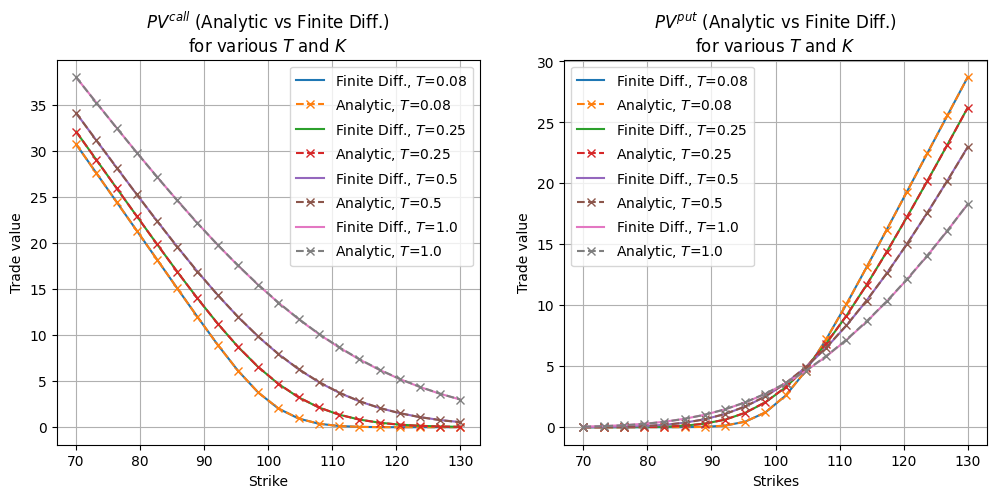

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, _ in enumerate(maturities):
    ax[0].plot(strikes, trade_values_calls[i], label="Finite Diff., $T$={}".format(round(maturities[i], 2)), linestyle="-")
    ax[0].plot(strikes, trade_values_calls_analytic[i], label="Analytic, $T$={}".format(round(maturities[i], 2)), linestyle="--", marker="x")

    ax[1].plot(strikes, trade_values_puts[i], label="Finite Diff., $T$={}".format(round(maturities[i], 2)), linestyle="-")
    ax[1].plot(strikes, trade_values_puts_analytic[i], label="Analytic, $T$={}".format(round(maturities[i], 2)), linestyle="--", marker="x")

ax[0].set_title('$PV^{call}$ (Analytic vs Finite Diff.)\n' + 'for various $T$ and $K$'), ax[0].set_xlabel('Strike'), ax[0].set_ylabel('Trade value'), ax[0].legend()
ax[1].set_title('$PV^{put}$ (Analytic vs Finite Diff.)\n' + 'for various $T$ and $K$'), ax[1].set_xlabel('Strikes'), ax[1].set_ylabel('Trade value'), ax[1].legend()
ax[0].grid(), ax[1].grid()
plt.show()

### References

1. Black, Fischer and Myron S. Scholes. “The Pricing of Options and Corporate Liabilities.” *Journal of Political Economy* 81 (1973): 637 - 654.

2.  Бахвалов, Корнев, Чижонков. Численные методы. Решения задач и упражнения» (2009)

3. Богачев, Практикум на ЭВМ. Методы решения линейных систем и нахождения собственных значений. (1998)